# Analisi Esplorativa dei Dati (EDA) - GUIDE Dataset: Microsoft Cybersecurity Incidents

Questo notebook esegue un'analisi esplorativa (EDA) sul dataset **GUIDE** (Guided Response Dataset) di Microsoft.

**Informazioni sul Dataset:**
- **GUIDE** è il più grande dataset pubblico di incidenti di cybersecurity reali
- Contiene oltre 13 milioni di evidenze attraverso 33 tipi di entità
- Copre 1.6 milioni di alert e 1 milione di incidenti annotati con etichette di triage
- Dati da oltre 6,100 organizzazioni
- 9,100 DetectorId unici e 441 tecniche MITRE ATT&CK
- Periodo di raccolta: 2 settimane

**Obiettivi dell'EDA:**
1.  Comprendere la struttura gerarchica del dataset (Evidence → Alert → Incident)
2.  Analizzare la distribuzione dei gradi di incidente (TP, BP, FP) - variabile target
3.  Esplorare le categorie di minacce e le tecniche MITRE ATT&CK
4.  Identificare pattern temporali, geografici e organizzativi
5.  Analizzare i dati mancanti e formulare strategie di gestione
6.  Preparare il dataset per il machine learning (predizione triage e azioni di remediation)

## 1. Setup: Importare le Librerie

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Impostazioni per una migliore visualizzazione
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Caricamento Dati

In [ ]:
# Carica il dataset GUIDE Training
file_path = '../data/GUIDE_Train.csv'

print("Caricamento del dataset GUIDE in corso...")
print("Questo potrebbe richiedere alcuni secondi dato che il dataset è molto grande (~9.5M righe)...\n")

df = pd.read_csv(file_path)

print(f"✓ Dataset caricato con successo!")
print(f"  - Righe: {df.shape[0]:,}")
print(f"  - Colonne: {df.shape[1]}")
print(f"  - Memoria utilizzata: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

In [ ]:
# Anteprima iniziale del dataset
print("\n--- Prime 10 righe del dataset ---")
df.head(10)

## 3. Ispezione Iniziale (Visione d'Insieme)

### 3.1 Dimensioni del Dataset

In [4]:
print(f"Il dataset ha {df.shape[0]} righe e {df.shape[1]} colonne.")

Il dataset ha 9516837 righe e 45 colonne.


### 3.2 Anteprima dei Dati

In [5]:
# Visualizza le prime 5 righe
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [6]:
# Visualizza le ultime 5 righe
df.tail()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
9516832,1056561956622,0,90,496631,2024-06-08T15:26:08.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
9516833,1228360650033,59,196410,748366,2024-06-06T09:40:08.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
9516834,867583395122,44,14117,7425,2024-06-11T22:51:03.000Z,78,57,Exfiltration,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
9516835,395136991850,43,644,8973,2024-05-20T23:01:01.000Z,52,10,Impact,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
9516836,678604833923,16,141721,644106,2024-06-03T23:51:52.000Z,24,348,Exfiltration,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


### 3.3 Tipi di Dati e Valori Mancanti (Sintesi)

In [7]:
# Ottiene informazioni sui tipi di colonna (Dtypes) e sui valori non nulli
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

### 3.4 Statistiche Descrittive

In [8]:
# Statistiche descrittive per le colonne numeriche
# (conteggio, media, deviazione standard, min, max, percentili)
df.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,...,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06
mean,8.425494e+11,1.815800e+02,7.066349e+04,4.065188e+05,1.106724e+02,2.947315e+03,9.566476e+04,1.287191e+05,2.857506e+05,1.503317e+05,...,3.342790e+03,8.807955e+02,2.622621e+05,1.076172e+05,3.583477e+03,4.898537e+00,6.465558e+01,2.236742e+02,1.351488e+03,9.936183e+03
std,4.962499e+11,3.867784e+02,1.208369e+05,4.592827e+05,4.351038e+02,1.146150e+04,1.635288e+04,3.399208e+04,1.412240e+05,3.750795e+04,...,5.103381e+02,1.291083e+01,8.152956e+04,3.220835e+04,9.020262e+01,7.035099e-01,9.314929e+00,6.279729e+01,3.509808e+02,2.606812e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.040000e+02,2.324200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.033600e+04,2.166520e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.710000e+02,8.432900e+04,6.715770e+05,4.500000e+01,1.800000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


In [20]:
# Statistiche descrittive per le colonne categoriche (tipo 'object')
# (conteggio, valori unici, valore più frequente, frequenza)
df.describe(include=['object'])

,Timestamp,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,ThreatFamily,ResourceType,Roles,AntispamDirection,SuspicionLevel,LastVerdict
count,9516837,9516837,4048451,9465497,56064,56064,9516837,9516837,74881,7075,218151,177302,1444129,2234265
unique,760944,20,1193,3,3,16,33,2,1745,25,10,5,2,5
top,2024-06-12T01:27:49.000Z,InitialAccess,T1078;T1078.004,BenignPositive,ContainAccount,update stsrefreshtokenvalidfrom timestamp.,Ip,Related,Phish,Virtual Machine,Contextual,Inbound,Suspicious,Suspicious
freq,11292,4293041,1354904,4110817,53760,21393,2181194,5208644,3526,4146,130528,161111,1442614,1402997


## 4. Pulizia Dati (Gestione Missing e Duplicati)

### 4.1 Valori Mancanti (NaN)

In [9]:
# Controlla il numero (e la percentuale) di valori mancanti per colonna
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Conteggio Mancanti': missing_values,
    'Percentuale (%)': missing_percent
}).sort_values(by='Percentuale (%)', ascending=False)

# Mostra solo le colonne con valori mancanti
missing_df[missing_df['Conteggio Mancanti'] > 0]

,Conteggio Mancanti,Percentuale (%)
ResourceType,9509762,99.925658
ActionGrouped,9460773,99.410897
ActionGranular,9460773,99.410897
ThreatFamily,9441956,99.213173
EmailClusterId,9420025,98.982729
AntispamDirection,9339535,98.136965
Roles,9298686,97.707736
SuspicionLevel,8072708,84.825536
LastVerdict,7282572,76.523030
MitreTechniques,5468386,57.460120


**Strategie per il Dataset GUIDE:**

**Colonne con mancanti >90% (ActionGrouped, ActionGranular, Email/Threat features):**
* Queste colonne saranno utilizzate solo per analisi secondarie (remediation action prediction)
* Per il task principale (triage prediction), queste features possono essere utilizzate come indicatori binari (presente/assente)

**MitreTechniques (~57% mancanti):**
* Creare una categoria "Unknown" per valori mancanti
* Estrarre il numero di tecniche come feature numerica
* One-hot encoding per le tecniche più comuni

**SuspicionLevel e LastVerdict (~85% e 77% mancanti):**
* Creare categoria "Unknown"
* Utilizzare come feature categorica con imputazione

**IncidentGrade (~0.5% mancanti):**
* Questi record possono essere rimossi poiché è la variabile target

In [ ]:
# Rimuovi record con IncidentGrade mancante (target)
print(f"Record prima della pulizia: {len(df):,}")
df = df[df['IncidentGrade'].notna()]
print(f"Record dopo rimozione IncidentGrade mancanti: {len(df):,}")
print(f"Record rimossi: {missing_values['IncidentGrade']:,}")

### 4.2 Dati Duplicati

In [10]:
# Verifica duplicati basati sull'ID univoco
num_duplicati_id = df['Id'].duplicated().sum()
print(f"Ci sono {num_duplicati_id} ID duplicati nel dataset.")

# Verifica duplicati completi (tutte le colonne)
num_duplicati_completi = df.duplicated().sum()
print(f"Ci sono {num_duplicati_completi} righe completamente duplicate nel dataset.")

Ci sono 22559 righe duplicate nel dataset.


In [12]:
# Se ci sono duplicati ID, li rimuoviamo (tenendo il primo)
if num_duplicati_id > 0:
    df = df.drop_duplicates(subset=['Id'], keep='first')
    print(f"✓ Dimensioni dopo rimozione duplicati: {df.shape}")

Dimensioni dopo rimozione duplicati: (9494278, 45)


## 5. Analisi Univariata (Analisi delle singole variabili)

Separiamo le colonne numeriche da quelle categoriche per analizzarle con i grafici appropriati.

**Note sul Dataset GUIDE:**
- Molte colonne numeriche sono ID anonimizzati (DeviceId, Sha256, IpAddress, etc.)
- Le colonne categoriche principali sono: Category, IncidentGrade, EntityType, EvidenceRole, SuspicionLevel, LastVerdict
- MitreTechniques può contenere tecniche multiple separate da virgola

In [13]:
colonne_numeriche = df.select_dtypes(include=np.number).columns.tolist()
colonne_categoriche = df.select_dtypes(include='object').columns.tolist()

# Rimuoviamo Timestamp dalle categoriche (lo trattiamo separatamente)
if 'Timestamp' in colonne_categoriche:
    colonne_categoriche.remove('Timestamp')

print("Colonne Numeriche:", colonne_numeriche)
print("\nColonne Categoriche:", colonne_categoriche)

Colonne Numeriche: ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City']
Colonne Categoriche: ['Timestamp', 'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


### 5.1 Analisi Variabili Numeriche Rilevanti

Le colonne numeriche nel dataset GUIDE sono principalmente ID anonimizzati.
Invece di visualizzare la distribuzione di questi ID, analizziamo il loro utilizzo (cardinalità).

In [ ]:
# Analisi della cardinalità (numero di valori unici) per colonne ID numeriche
print("Cardinalità delle colonne numeriche (ID):\n")
cardinality_info = []
for col in colonne_numeriche:
    unique_count = df[col].nunique()
    total_count = df[col].count()
    missing_count = df[col].isna().sum()
    cardinality_info.append({
        'Colonna': col,
        'Valori Unici': unique_count,
        'Valori Totali': total_count,
        'Valori Mancanti': missing_count,
        'Cardinalità %': (unique_count / total_count * 100) if total_count > 0 else 0
    })

cardinality_df = pd.DataFrame(cardinality_info).sort_values('Valori Unici', ascending=False)
cardinality_df

In [ ]:
# Visualizziamo la cardinalità delle principali colonne ID
plt.figure(figsize=(14, 8))
top_cardinality = cardinality_df.head(15)
sns.barplot(data=top_cardinality, y='Colonna', x='Valori Unici', palette='viridis')
plt.title('Cardinalità delle Top 15 Colonne Numeriche (ID)', fontsize=14)
plt.xlabel('Numero di Valori Unici')
plt.ylabel('Colonna')
plt.tight_layout()
plt.show()

### 5.2 Analisi Variabili Categoriche Principali

In [ ]:
# Definiamo le colonne categoriche più importanti per l'analisi
colonne_categoriche_rilevanti = ['IncidentGrade', 'Category', 'EntityType', 'EvidenceRole',
                                  'SuspicionLevel', 'LastVerdict']

# Verifica che esistano nel dataset
colonne_categoriche_rilevanti = [col for col in colonne_categoriche_rilevanti if col in df.columns]

print(f"Colonne categoriche da analizzare: {colonne_categoriche_rilevanti}")

In [ ]:
# Countplot per le variabili categoriche rilevanti
for col in colonne_categoriche_rilevanti:
    plt.figure(figsize=(12, 6))

    # Prendi i top valori (massimo 20 per leggibilità)
    value_counts = df[col].value_counts()
    if len(value_counts) > 20:
        top_values = value_counts.head(20).index
        data_to_plot = df[df[col].isin(top_values)]
        title_suffix = ' (Top 20)'
    else:
        data_to_plot = df
        title_suffix = ''

    sns.countplot(y=col, data=data_to_plot, order=data_to_plot[col].value_counts().index, palette='Set2')
    plt.title(f'Distribuzione di {col}{title_suffix}', fontsize=14)
    plt.xlabel('Conteggio')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    # Stampa le statistiche
    print(f"\n{col} - Statistiche:")
    print(f"  Valori unici: {df[col].nunique()}")
    print(f"  Valori mancanti: {df[col].isna().sum()} ({df[col].isna().sum()/len(df)*100:.2f}%)")
    print(f"  Top 5 valori:")
    print(df[col].value_counts().head(5))
    print("-" * 80)

## 6. Analisi Bivariata e Multivariata (Relazioni)

### 6.1 Analisi delle Relazioni Principali

Nel dataset GUIDE, le colonne numeriche sono ID anonimizzati, quindi le classiche matrici di correlazione
non sono particolarmente informative. Ci concentriamo sulle relazioni tra variabili categoriche e la target.

In [ ]:
# Analisi della relazione tra Category e IncidentGrade
plt.figure(figsize=(16, 8))
category_incident_crosstab = pd.crosstab(df['Category'], df['IncidentGrade'], normalize='index') * 100
category_incident_crosstab.plot(kind='bar', figsize=(16, 8), colormap='viridis')
plt.title('Distribuzione Percentuale di IncidentGrade per Categoria di Minaccia', fontsize=14)
plt.xlabel('Categoria')
plt.ylabel('Percentuale (%)')
plt.legend(title='Incident Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Analisi della relazione tra EntityType e IncidentGrade
if 'EntityType' in df.columns:
    plt.figure(figsize=(14, 8))
    entity_incident_crosstab = pd.crosstab(df['EntityType'], df['IncidentGrade'], normalize='index') * 100

    # Mostra solo i top 15 EntityType più comuni
    top_entities = df['EntityType'].value_counts().head(15).index
    entity_incident_crosstab.loc[top_entities].plot(kind='bar', figsize=(14, 8), colormap='plasma')
    plt.title('Distribuzione IncidentGrade per EntityType (Top 15)', fontsize=14)
    plt.xlabel('Entity Type')
    plt.ylabel('Percentuale (%)')
    plt.legend(title='Incident Grade')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# Analisi della relazione tra EvidenceRole e IncidentGrade
if 'EvidenceRole' in df.columns:
    plt.figure(figsize=(14, 6))
    role_incident_crosstab = pd.crosstab(df['EvidenceRole'], df['IncidentGrade'], normalize='index') * 100
    role_incident_crosstab.plot(kind='bar', figsize=(14, 6), colormap='coolwarm')
    plt.title('Distribuzione IncidentGrade per EvidenceRole', fontsize=14)
    plt.xlabel('Evidence Role')
    plt.ylabel('Percentuale (%)')
    plt.legend(title='Incident Grade')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### 6.2 Analisi Temporale vs IncidentGrade

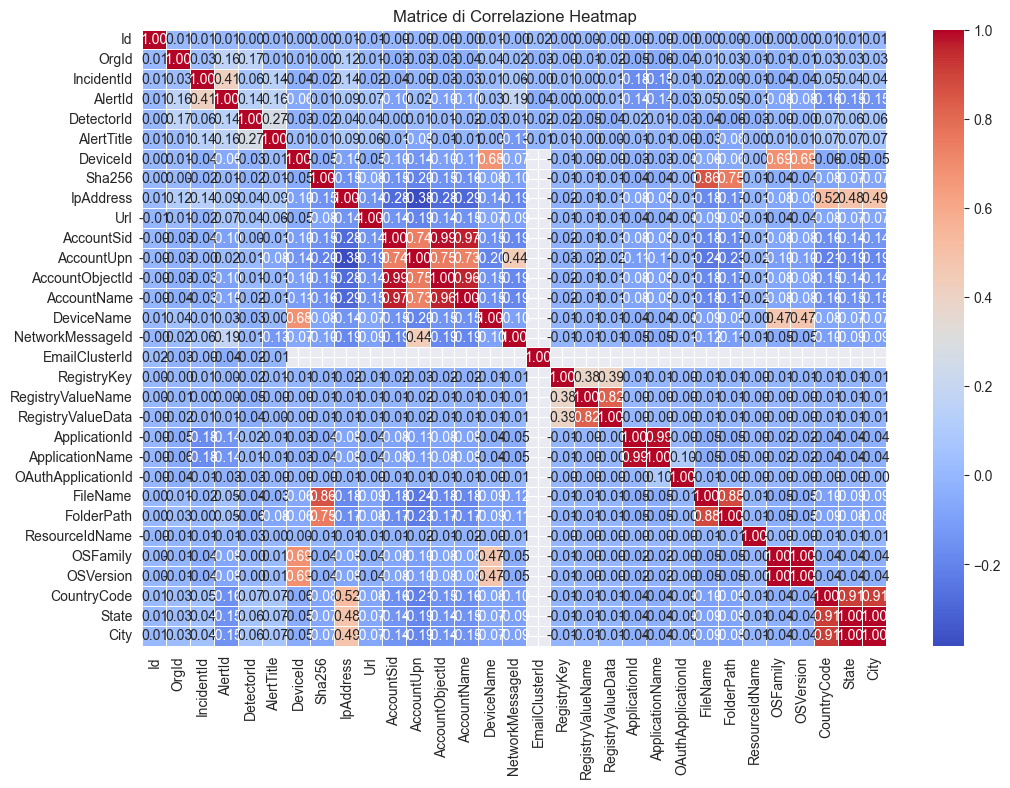

In [15]:
# Distribuzione di IncidentGrade per ora del giorno
if 'Hour' in df.columns:
    plt.figure(figsize=(14, 6))
    hour_grade_crosstab = pd.crosstab(df['Hour'], df['IncidentGrade'], normalize='index') * 100
    hour_grade_crosstab.plot(kind='bar', figsize=(14, 6))
    plt.title('Distribuzione IncidentGrade per Ora del Giorno', fontsize=14)
    plt.xlabel('Ora')
    plt.ylabel('Percentuale (%)')
    plt.legend(title='Incident Grade')
    plt.tight_layout()
    plt.show()

In [ ]:
# Distribuzione di IncidentGrade per giorno della settimana
if 'DayOfWeek' in df.columns:
    plt.figure(figsize=(12, 6))
    day_grade_crosstab = pd.crosstab(df['DayOfWeek'], df['IncidentGrade'], normalize='index') * 100
    day_names = ['Lun', 'Mar', 'Mer', 'Gio', 'Ven', 'Sab', 'Dom']
    day_grade_crosstab.index = [day_names[i] for i in day_grade_crosstab.index]
    day_grade_crosstab.plot(kind='bar', figsize=(12, 6))
    plt.title('Distribuzione IncidentGrade per Giorno della Settimana', fontsize=14)
    plt.xlabel('Giorno')
    plt.ylabel('Percentuale (%)')
    plt.legend(title='Incident Grade')
    plt.tight_layout()
    plt.show()

### 6.3 Analisi delle Co-occorrenze (Incident/Alert Level)

In [17]:
# Analisi a livello di Incident: quanti alert per incident?
if 'IncidentId' in df.columns:
    alerts_per_incident = df.groupby('IncidentId')['AlertId'].nunique()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(alerts_per_incident, bins=50, kde=True, color='steelblue')
    plt.title('Distribuzione: Numero di Alert per Incident')
    plt.xlabel('Numero di Alert')
    plt.ylabel('Frequenza')
    plt.xlim(0, min(50, alerts_per_incident.max()))

    plt.subplot(1, 2, 2)
    sns.boxplot(x=alerts_per_incident, color='coral')
    plt.title('Boxplot: Alert per Incident')
    plt.xlabel('Numero di Alert')

    plt.tight_layout()
    plt.show()

    print(f"Statistiche Alert per Incident:")
    print(f"  Media: {alerts_per_incident.mean():.2f}")
    print(f"  Mediana: {alerts_per_incident.median():.2f}")
    print(f"  Min: {alerts_per_incident.min()}")
    print(f"  Max: {alerts_per_incident.max()}")

KeyboardInterrupt: 

In [ ]:
# Analisi a livello di Alert: quante evidenze per alert?
if 'AlertId' in df.columns:
    evidences_per_alert = df.groupby('AlertId').size()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(evidences_per_alert, bins=50, kde=True, color='purple')
    plt.title('Distribuzione: Numero di Evidenze per Alert')
    plt.xlabel('Numero di Evidenze')
    plt.ylabel('Frequenza')
    plt.xlim(0, min(50, evidences_per_alert.max()))

    plt.subplot(1, 2, 2)
    sns.boxplot(x=evidences_per_alert, color='orange')
    plt.title('Boxplot: Evidenze per Alert')
    plt.xlabel('Numero di Evidenze')

    plt.tight_layout()
    plt.show()

    print(f"Statistiche Evidenze per Alert:")
    print(f"  Media: {evidences_per_alert.mean():.2f}")
    print(f"  Mediana: {evidences_per_alert.median():.2f}")
    print(f"  Min: {evidences_per_alert.min()}")
    print(f"  Max: {evidences_per_alert.max()}")

## 7. Conclusioni Iniziali e Prossimi Passi

### 7.1 Analisi Specifica per Cybersecurity

In questa sezione analizziamo gli aspetti specifici del dataset GUIDE relativi alla sicurezza informatica.

In [ ]:
# Analisi della distribuzione dei IncidentGrade (variabile target)
plt.figure(figsize=(12, 6))
incident_grade_counts = df['IncidentGrade'].value_counts()
sns.barplot(x=incident_grade_counts.index, y=incident_grade_counts.values, palette='viridis')
plt.title('Distribuzione degli Incident Grades (Variabile Target)', fontsize=14)
plt.xlabel('Incident Grade')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
for i, v in enumerate(incident_grade_counts.values):
    plt.text(i, v + 50000, f'{v:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("\nProporzioni Incident Grade:")
print(df['IncidentGrade'].value_counts(normalize=True) * 100)

In [ ]:
# Analisi delle categorie di minacce (MITRE ATT&CK Framework)
plt.figure(figsize=(14, 8))
category_counts = df['Category'].value_counts().head(15)
sns.barplot(y=category_counts.index, x=category_counts.values, palette='rocket')
plt.title('Top 15 Categorie di Minacce (MITRE ATT&CK)', fontsize=14)
plt.xlabel('Frequenza')
plt.ylabel('Categoria')
plt.tight_layout()
plt.show()

In [ ]:
# Analisi temporale: distribuzione degli incidenti nel tempo
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Date'] = df['Timestamp'].dt.date

# Incidenti per ora del giorno
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
hour_counts = df['Hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='steelblue')
plt.title('Distribuzione Incidenti per Ora del Giorno')
plt.xlabel('Ora')
plt.ylabel('Numero di Incidenti')

# Incidenti per giorno della settimana
plt.subplot(1, 2, 2)
day_counts = df['DayOfWeek'].value_counts().sort_index()
day_names = ['Lun', 'Mar', 'Mer', 'Gio', 'Ven', 'Sab', 'Dom']
sns.barplot(x=[day_names[i] for i in day_counts.index], y=day_counts.values, color='coral')
plt.title('Distribuzione Incidenti per Giorno della Settimana')
plt.xlabel('Giorno')
plt.ylabel('Numero di Incidenti')
plt.tight_layout()
plt.show()

In [ ]:
# Analisi delle MITRE Techniques più comuni
mitre_techniques = df['MitreTechniques'].dropna()
if len(mitre_techniques) > 0:
    # Alcune righe potrebbero contenere multiple tecniche separate da virgola
    all_techniques = []
    for tech in mitre_techniques:
        if isinstance(tech, str):
            all_techniques.extend([t.strip() for t in tech.split(',')])

    technique_counts = pd.Series(all_techniques).value_counts().head(15)

    plt.figure(figsize=(14, 8))
    sns.barplot(y=technique_counts.index, x=technique_counts.values, palette='magma')
    plt.title('Top 15 MITRE ATT&CK Techniques', fontsize=14)
    plt.xlabel('Frequenza')
    plt.ylabel('Tecnica MITRE')
    plt.tight_layout()
    plt.show()

In [ ]:
# Analisi IncidentGrade vs Category
plt.figure(figsize=(16, 8))
category_grade_crosstab = pd.crosstab(df['Category'], df['IncidentGrade'], normalize='index') * 100
top_categories = df['Category'].value_counts().head(10).index
category_grade_crosstab.loc[top_categories].plot(kind='bar', stacked=False, figsize=(16, 8))
plt.title('Distribuzione IncidentGrade per Categoria di Minaccia (Top 10 Categorie)', fontsize=14)
plt.xlabel('Categoria')
plt.ylabel('Percentuale (%)')
plt.legend(title='Incident Grade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Analisi degli Organizations (OrgId)
print(f"Numero di organizzazioni uniche nel dataset: {df['OrgId'].nunique()}")
print(f"Numero di DetectorId unici: {df['DetectorId'].nunique()}")
print(f"Numero di EntityType unici: {df['EntityType'].nunique()}")

# Distribuzione incidenti per organizzazione (top 20)
plt.figure(figsize=(14, 6))
org_counts = df['OrgId'].value_counts().head(20)
sns.barplot(x=org_counts.index.astype(str), y=org_counts.values, palette='coolwarm')
plt.title('Top 20 Organizzazioni per Numero di Incidenti')
plt.xlabel('Organization ID')
plt.ylabel('Numero di Incidenti')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Analisi dei Verdict e SuspicionLevel
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Last Verdict
if df['LastVerdict'].notna().sum() > 0:
    verdict_counts = df['LastVerdict'].value_counts()
    axes[0].pie(verdict_counts.values, labels=verdict_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Distribuzione Last Verdict')
else:
    axes[0].text(0.5, 0.5, 'Dati non disponibili', ha='center', va='center')
    axes[0].set_title('Distribuzione Last Verdict')

# Suspicion Level
if df['SuspicionLevel'].notna().sum() > 0:
    suspicion_counts = df['SuspicionLevel'].value_counts()
    axes[1].pie(suspicion_counts.values, labels=suspicion_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Distribuzione Suspicion Level')
else:
    axes[1].text(0.5, 0.5, 'Dati non disponibili', ha='center', va='center')
    axes[1].set_title('Distribuzione Suspicion Level')

plt.tight_layout()
plt.show()

In [ ]:
# Analisi geografica (CountryCode, State, City)
print(f"Numero di paesi unici: {df['CountryCode'].nunique()}")
print(f"Numero di stati/regioni uniche: {df['State'].nunique()}")
print(f"Numero di città uniche: {df['City'].nunique()}")

# Top 10 paesi per numero di incidenti
plt.figure(figsize=(12, 6))
country_counts = df['CountryCode'].value_counts().head(10)
sns.barplot(x=country_counts.index.astype(str), y=country_counts.values, palette='Set2')
plt.title('Top 10 Paesi per Numero di Incidenti (Country Code)')
plt.xlabel('Country Code')
plt.ylabel('Numero di Incidenti')
plt.tight_layout()
plt.show()

In [ ]:
# Analisi OS Family e OS Version
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# OS Family
os_family_counts = df['OSFamily'].value_counts().head(10)
axes[0].barh(os_family_counts.index.astype(str), os_family_counts.values, color='teal')
axes[0].set_title('Top 10 OS Family')
axes[0].set_xlabel('Numero di Incidenti')
axes[0].set_ylabel('OS Family ID')

# OS Version
os_version_counts = df['OSVersion'].value_counts().head(10)
axes[1].barh(os_version_counts.index.astype(str), os_version_counts.values, color='navy')
axes[1].set_title('Top 10 OS Version')
axes[1].set_xlabel('Numero di Incidenti')
axes[1].set_ylabel('OS Version ID')

plt.tight_layout()
plt.show()

### 7.2 Analisi delle Azioni di Remediation (per subset con ActionGrouped/ActionGranular)

In [ ]:
# Verifica se ci sono dati sulle azioni
actions_available = df['ActionGrouped'].notna().sum()
print(f"Numero di record con ActionGrouped disponibili: {actions_available} ({actions_available/len(df)*100:.2f}%)")

if actions_available > 0:
    df_with_actions = df[df['ActionGrouped'].notna()]

    # Distribuzione ActionGrouped
    plt.figure(figsize=(12, 6))
    action_grouped_counts = df_with_actions['ActionGrouped'].value_counts().head(15)
    sns.barplot(y=action_grouped_counts.index.astype(str), x=action_grouped_counts.values, palette='viridis')
    plt.title('Top 15 Azioni Raggruppate (ActionGrouped)')
    plt.xlabel('Frequenza')
    plt.ylabel('Action ID')
    plt.tight_layout()
    plt.show()

    # Relazione tra IncidentGrade e ActionGrouped
    if len(df_with_actions) > 0:
        plt.figure(figsize=(14, 8))
        action_grade_crosstab = pd.crosstab(
            df_with_actions['ActionGrouped'],
            df_with_actions['IncidentGrade'],
            normalize='index'
        ) * 100
        action_grade_crosstab.head(10).plot(kind='bar', stacked=False, figsize=(14, 8))
        plt.title('Distribuzione IncidentGrade per Tipo di Azione (Top 10 Azioni)')
        plt.xlabel('Action ID')
        plt.ylabel('Percentuale (%)')
        plt.legend(title='Incident Grade')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("Nessun dato sulle azioni di remediation disponibile nel training set.")

## 8. Conclusioni Iniziali e Prossimi Passi

**Riassunto Dataset GUIDE:**

* **Dimensioni:** Il dataset contiene circa 9.5 milioni di record di evidenze/alert relativi a incidenti di cybersecurity
* **Periodo:** I dati coprono un periodo di 2 settimane (giugno 2024)
* **Organizzazioni:** Dati da oltre 6,100 organizzazioni diverse
* **Variabile Target:** `IncidentGrade` con 3 classi: TruePositive (TP), BenignPositive (BP), FalsePositive (FP)

**Qualità dei Dati:**

* **Valori Mancanti:** Molte colonne hanno un'alta percentuale di valori mancanti (es: ActionGrouped/ActionGranular ~99%, MitreTechniques ~57%)
* **Duplicati:** Da verificare (consigliato basarsi su Id univoco)
* **Anonimizzazione:** I dati sono stati anonimizzati tramite SHA1 hashing e ID casuali

**Distribuzioni Principali:**

* **IncidentGrade:** BenignPositive (~43%), TruePositive (~35%), FalsePositive (~21%) - dataset sbilanciato
* **Categorie:** InitialAccess è la categoria più frequente, seguito da Exfiltration e SuspiciousActivity
* **Tecniche MITRE:** 441 tecniche ATT&CK diverse presenti nel dataset
* **DetectorId:** Oltre 9,100 rilevatori unici utilizzati

**Pattern Temporali:**

* Analizzare se ci sono pattern orari o giornalieri nella distribuzione degli incidenti
* Verificare se certe categorie di minacce sono più frequenti in determinati momenti

**Prossimi Passi (Feature Engineering & Modeling):**

1. **Gestione Valori Mancanti:**
   * Decidere strategia per MitreTechniques (es: creare categoria "Unknown")
   * Gestire ActionGrouped/ActionGranular (solo ~1% dei dati)
   * Imputare o rimuovere SuspicionLevel, LastVerdict basandosi sull'analisi

2. **Feature Engineering:**
   * Estrarre features temporali da Timestamp (ora, giorno settimana, periodo giornata)
   * Creare aggregazioni a livello IncidentId (numero di alert, tipi di evidenze)
   * One-Hot Encoding per variabili categoriche (Category, EntityType, EvidenceRole)
   * Feature da MITRE Techniques (conteggio, categorie)
   * Aggregazioni geografiche (CountryCode, State, City)

3. **Trattamento Sbilanciamento Classi:**
   * Considerare tecniche di resampling (SMOTE, undersampling)
   * Utilizzare metriche appropriate (macro-F1, precision, recall per classe)
   * Stratified K-Fold per cross-validation

4. **Modeling:**
   * Modelli baseline: Logistic Regression, Random Forest
   * Modelli avanzati: XGBoost, LightGBM, CatBoost
   * Deep Learning: Neural Networks per pattern complessi
   * Ottimizzazione iperparametri con focus su macro-F1 score

5. **Analisi Avanzate:**
   * Studio delle relazioni tra DetectorId e IncidentGrade
   * Analisi delle organizzazioni più colpite e pattern associati
   * Correlazione tra multiple evidenze nello stesso incidente
   * Time-series analysis per detection patterns
